In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd

train = pd.read_csv("./titanic_train.csv")
test = pd.read_csv("./titanic_test.csv")

In [2]:
train = train.dropna(axis =1 )
test = test.dropna(axis = 1)


In [3]:
col = list(set(train.columns) & set(test.columns))
col = ['SibSp', 'Sex', 'Pclass', 'Parch']
data = np.concatenate( (train.loc[:,col].values  , test.loc[:,col].values) , axis = 0)



In [4]:
data = pd.DataFrame(data).replace("male" , 0 )
data = pd.DataFrame(data).replace("female" , 1 )


In [5]:
feature = col

data = data.values


def sample_data(n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output


In [6]:
input_dim = np.shape(data)[1]

def generator(Z,hsize=[24, 24 , 24 ],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h2,hsize[2],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,input_dim)  # activation=None  -> linear 라는 의미 
    return out


def discriminator(X,hsize=[24, 24],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1) # activation=None

    return out, h3

In [7]:

X = tf.placeholder(tf.float32,[None,input_dim ])
Z = tf.placeholder(tf.float32,[None,input_dim ])

In [8]:
G_sample = generator(Z)
Floor_G =  tf.floor(G_sample)
residual = tf.subtract(Floor_G , G_sample)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

In [9]:
disc_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
    tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))

gen_loss = tf.add(10*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits))) ,tf.reduce_mean(residual))


In [10]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


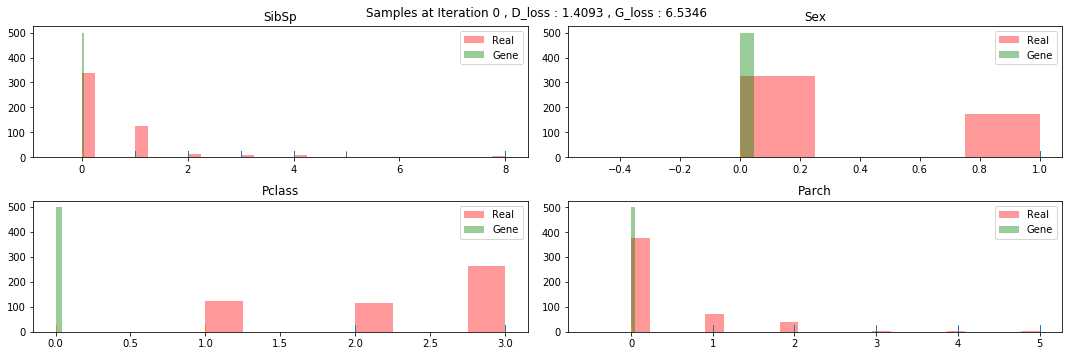

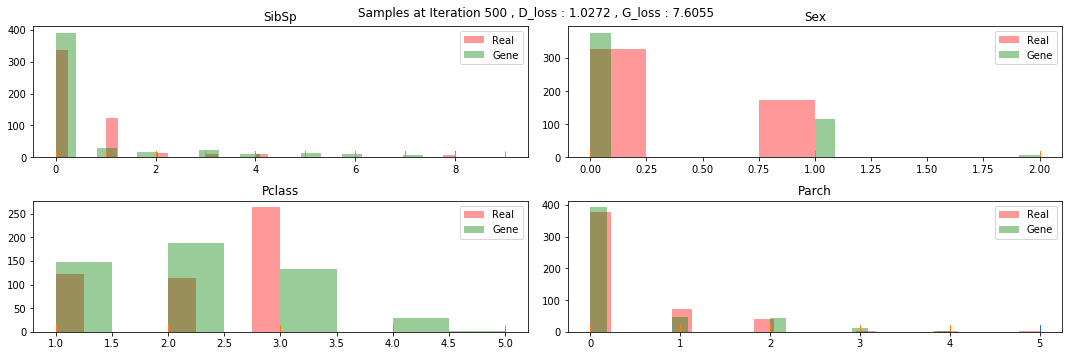

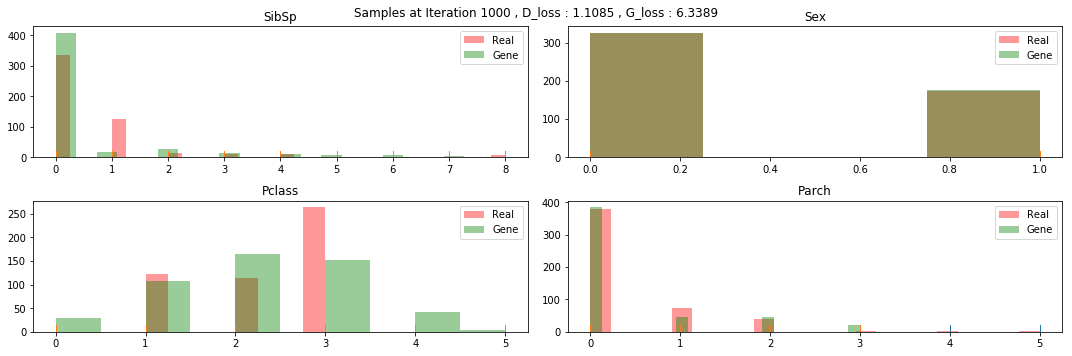

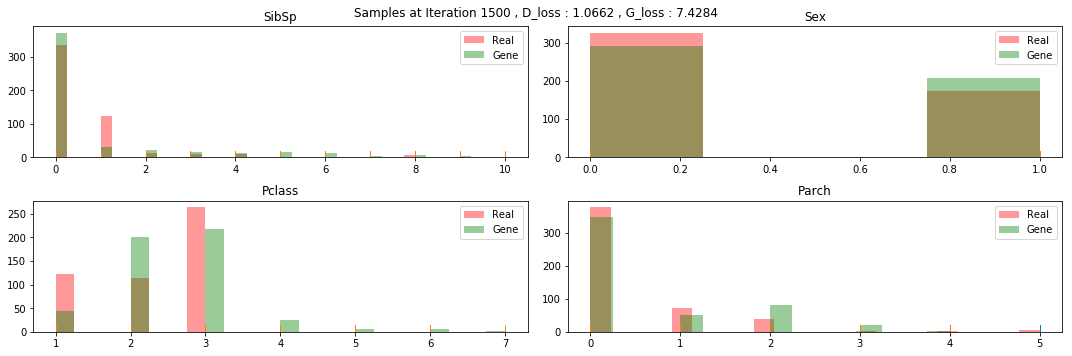

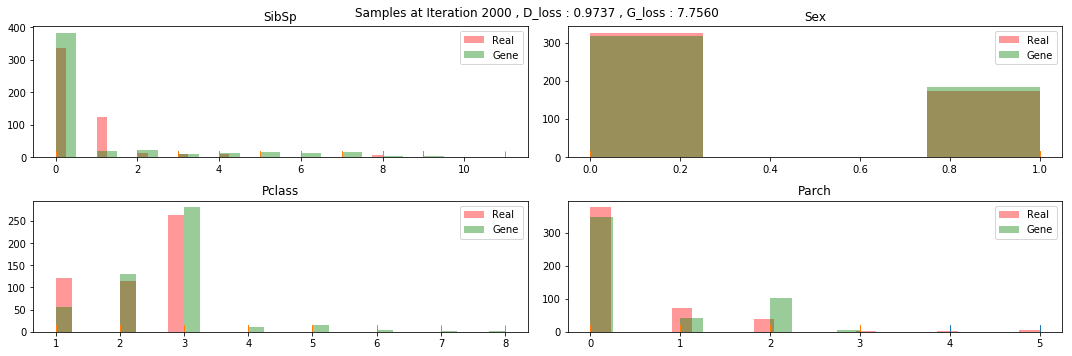

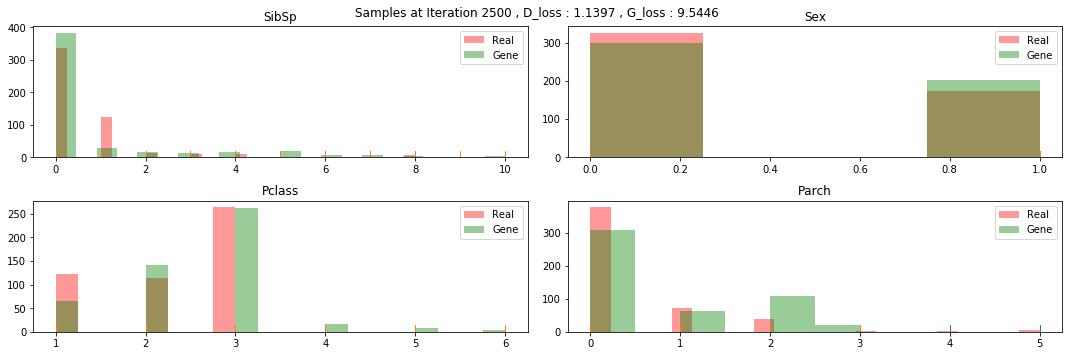

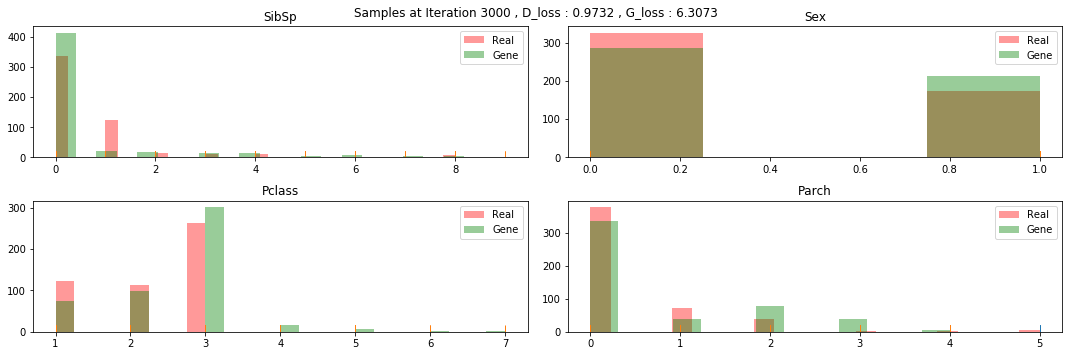

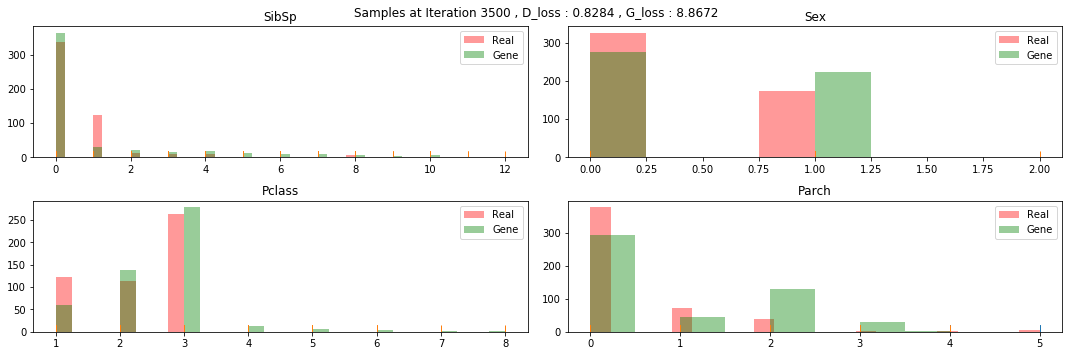

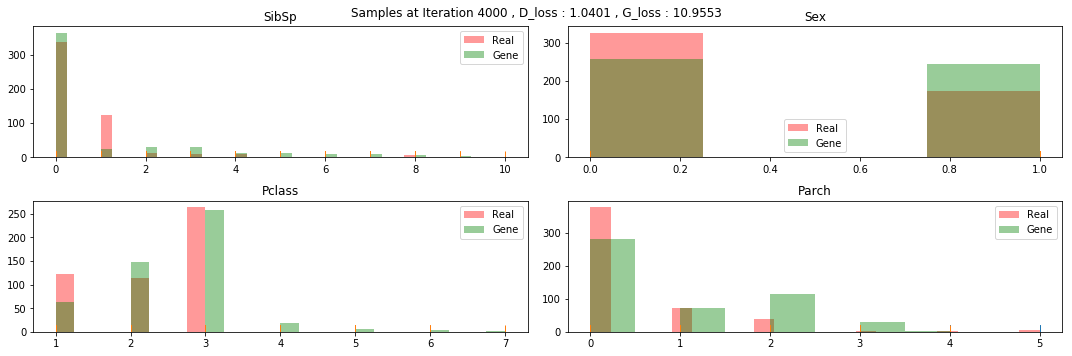

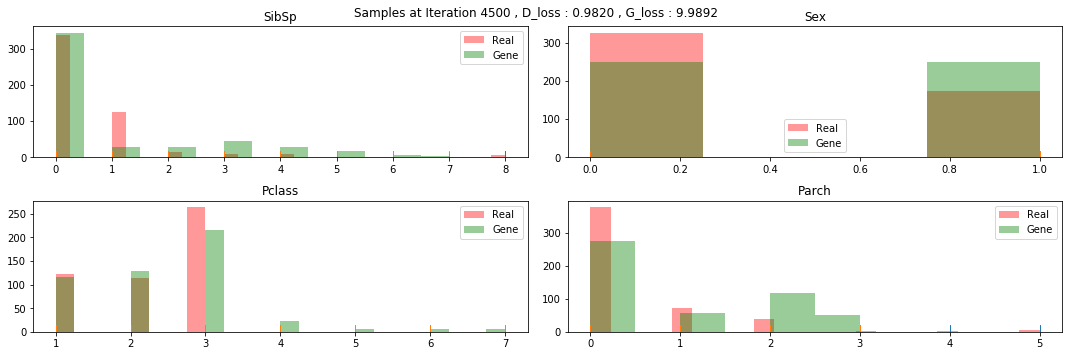

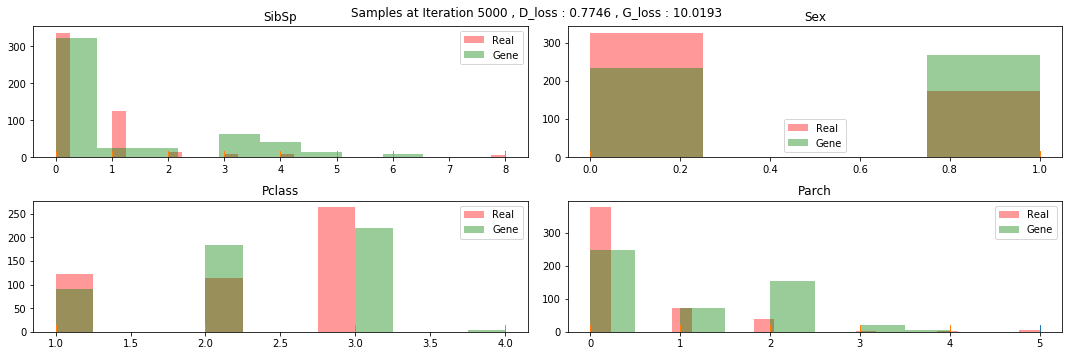

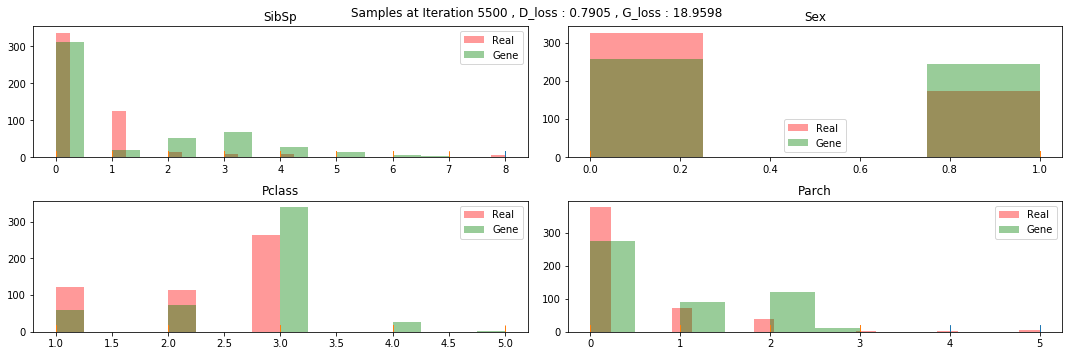

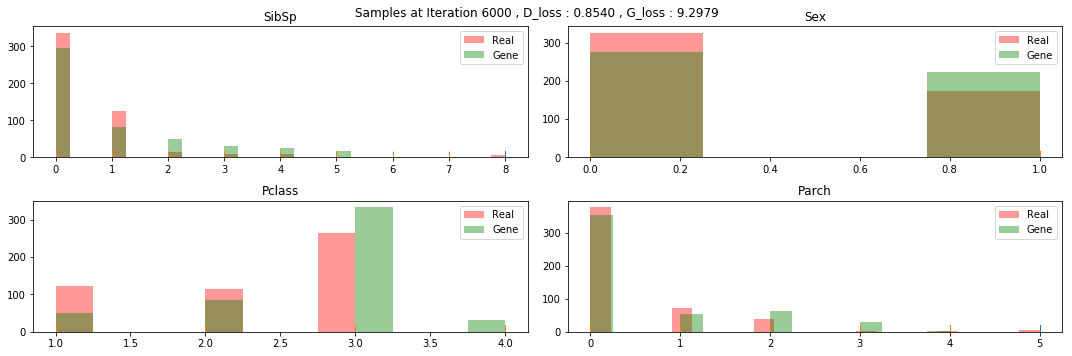

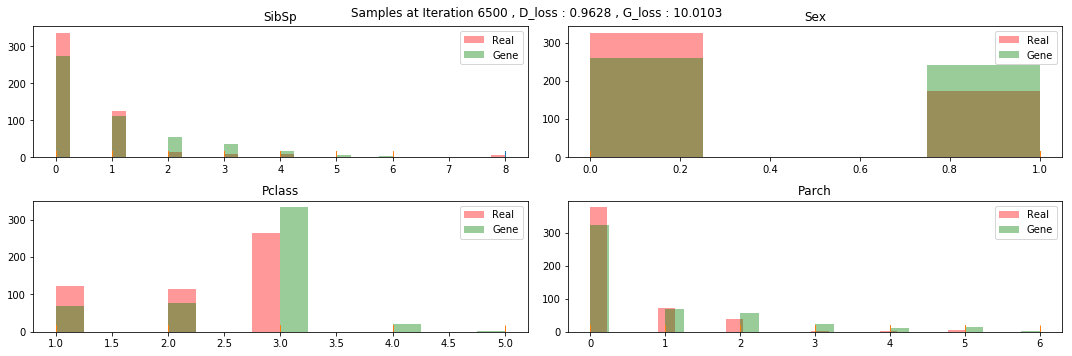

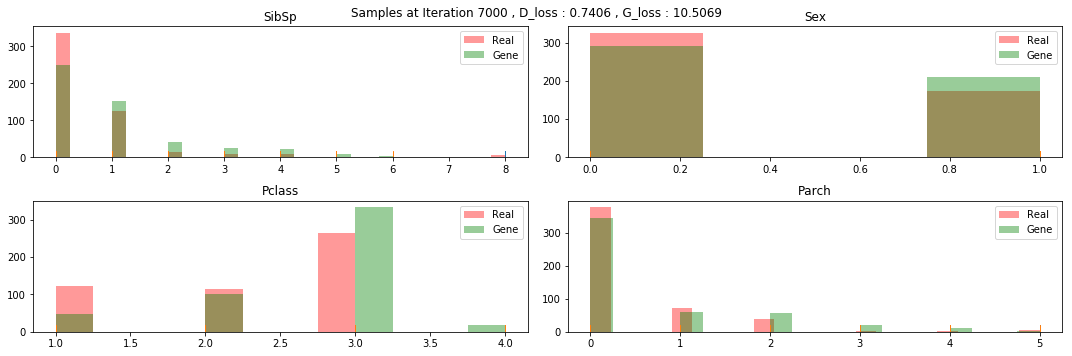

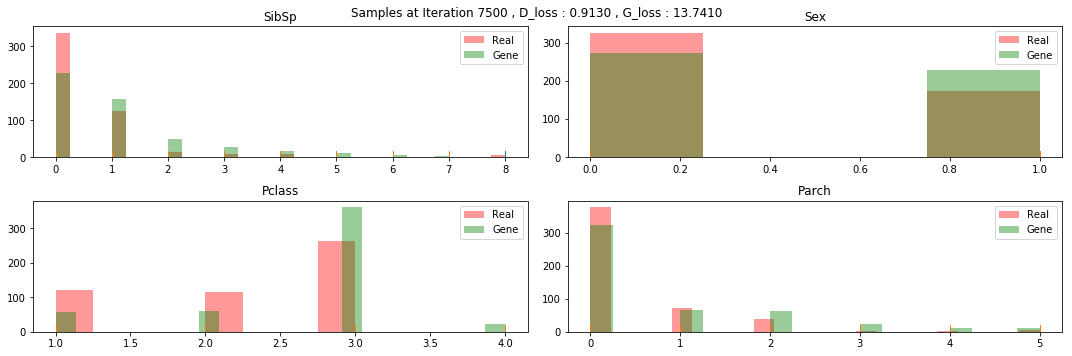

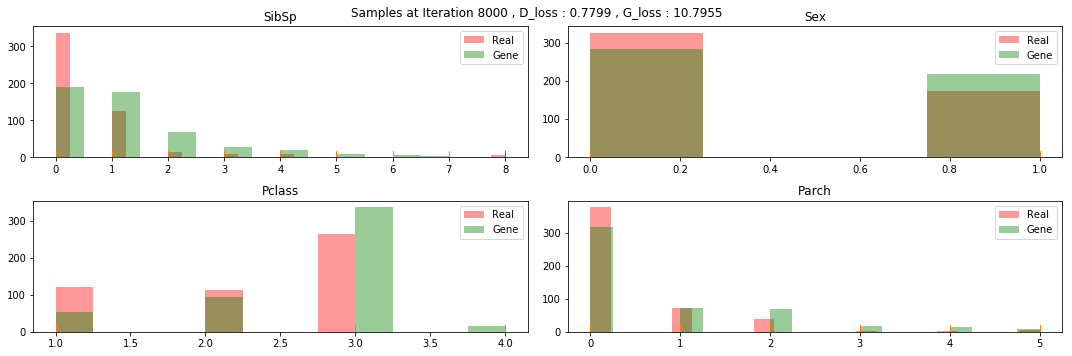

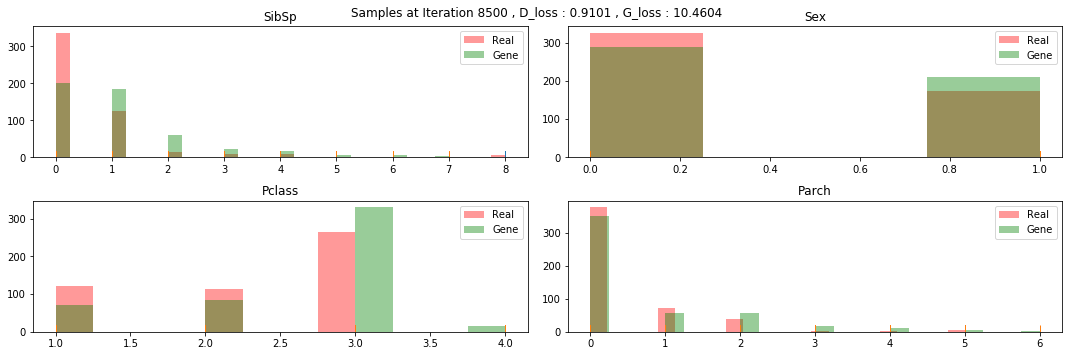

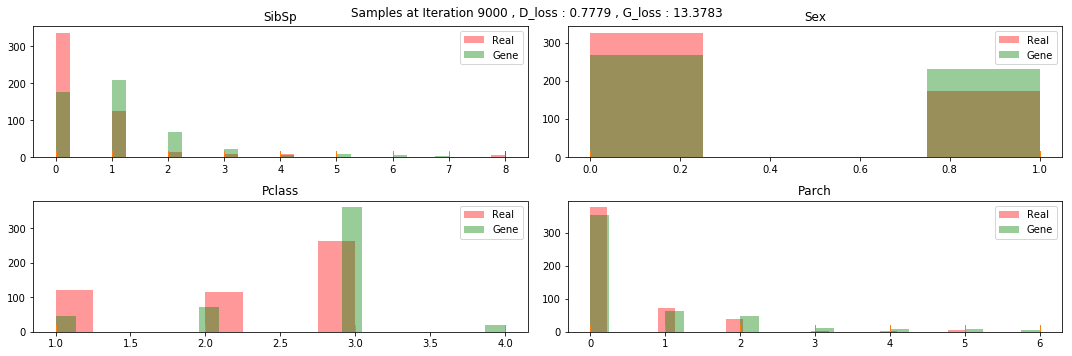

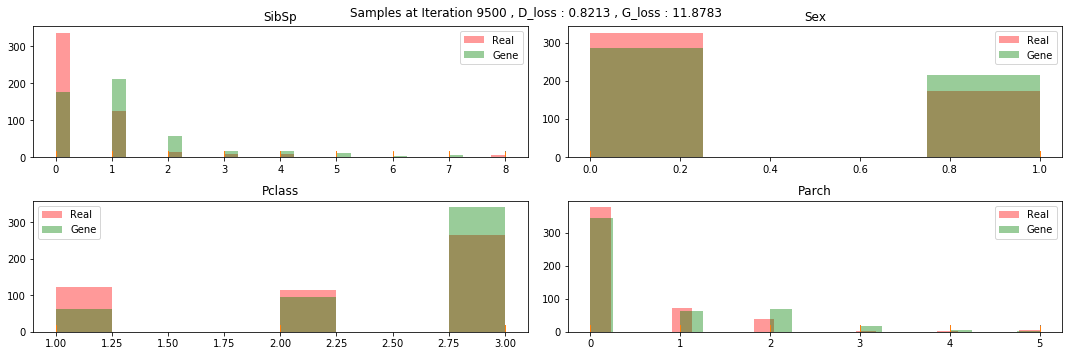

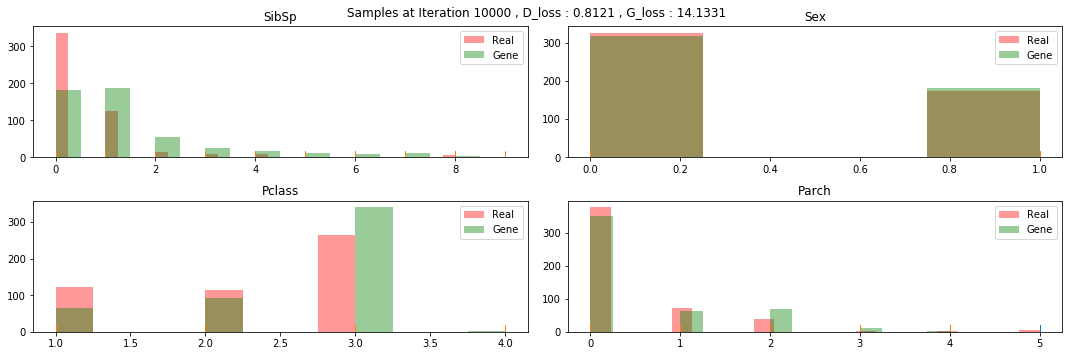

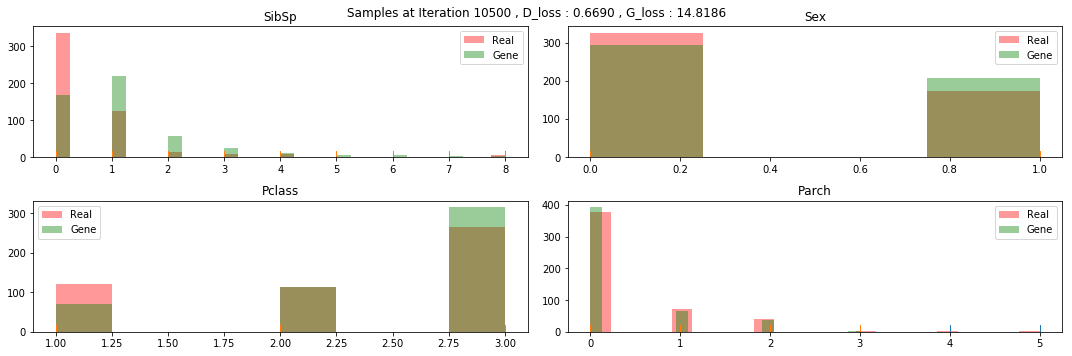

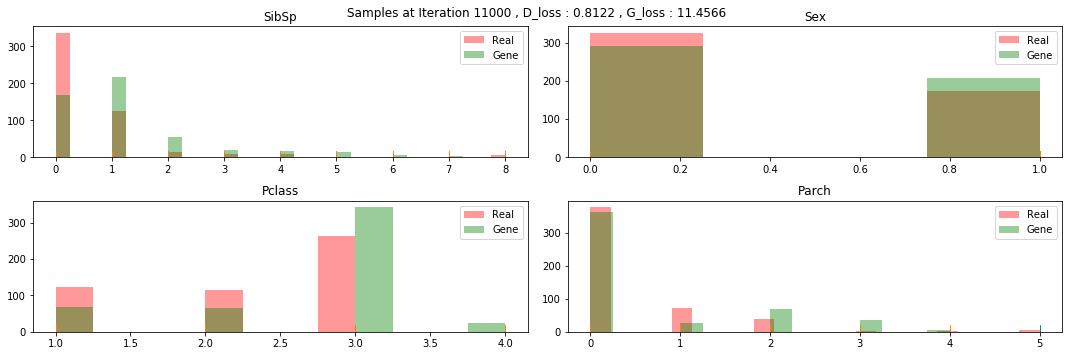

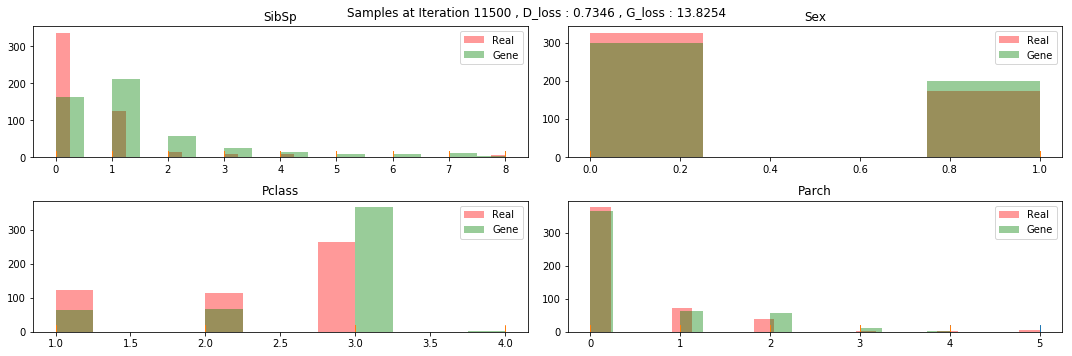

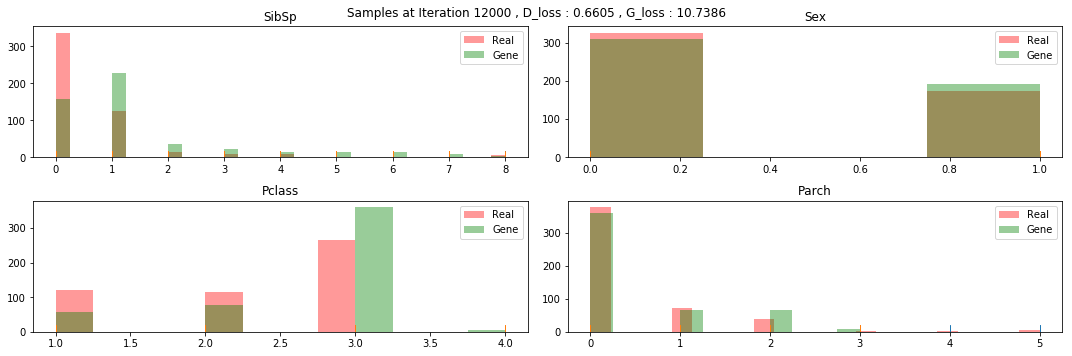

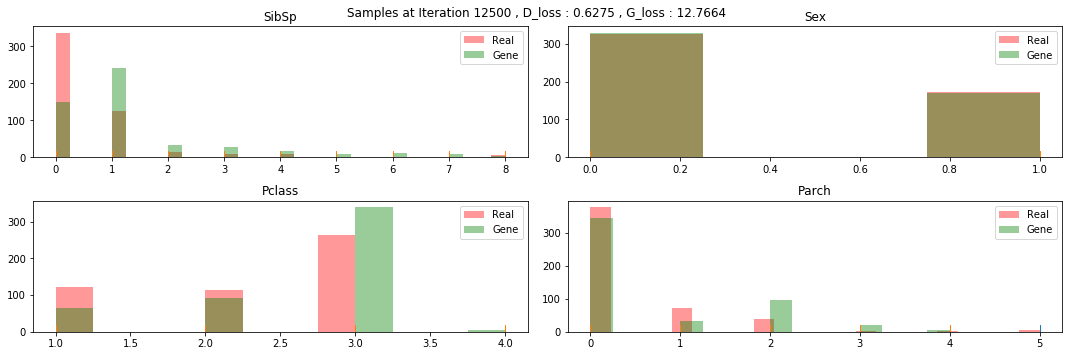

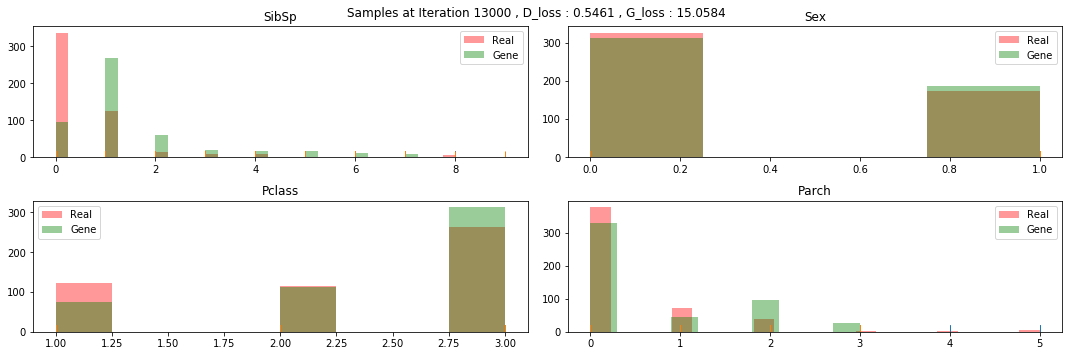

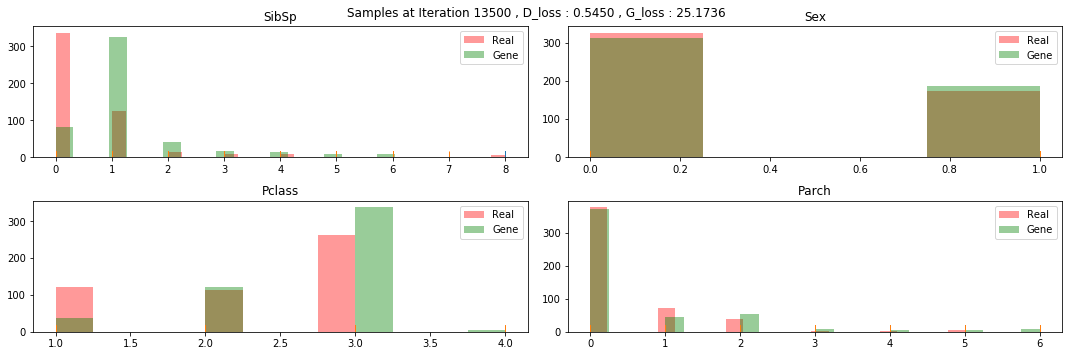

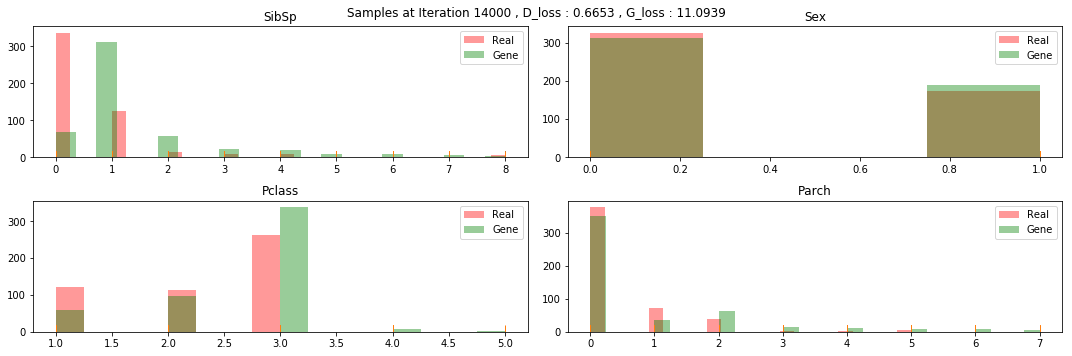

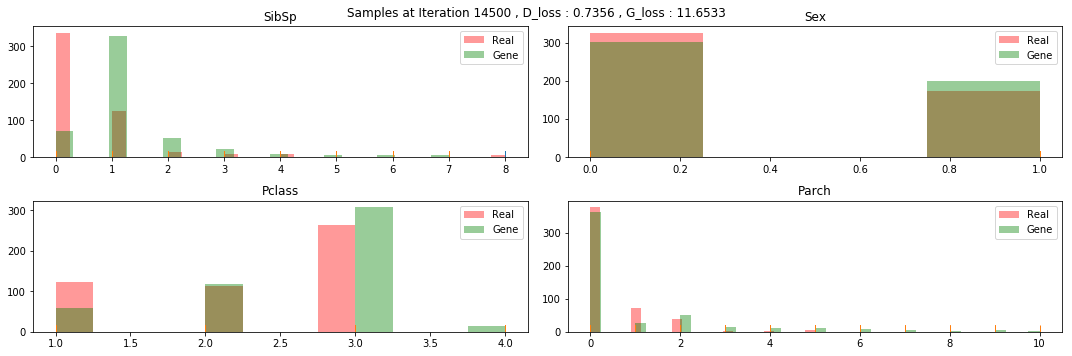

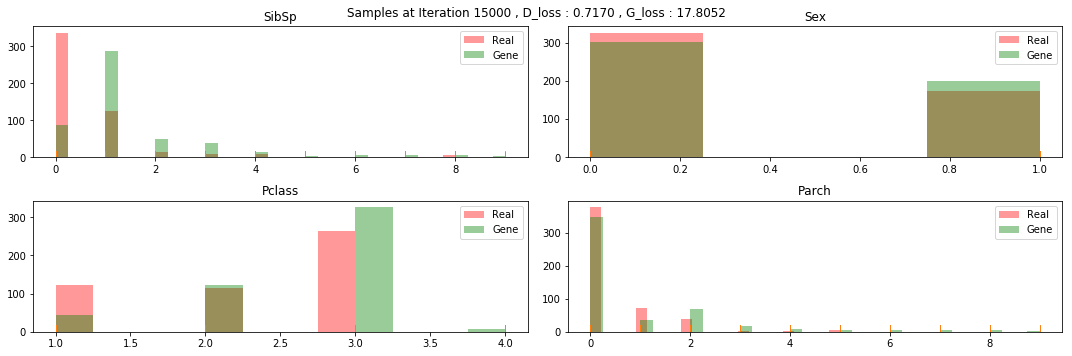

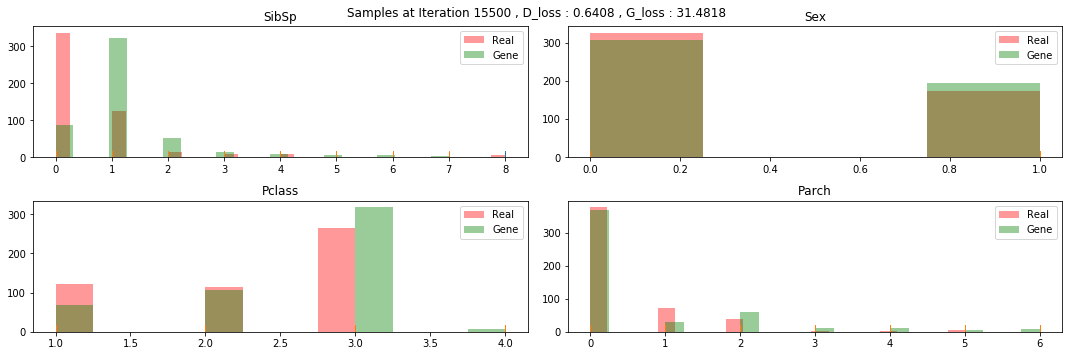

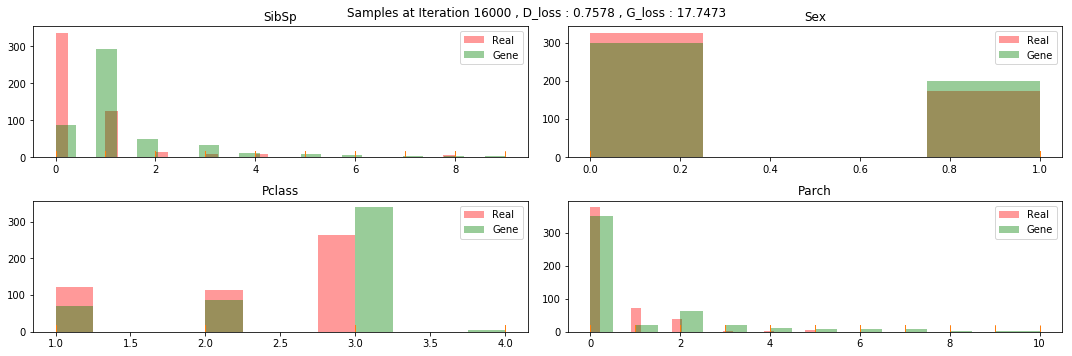

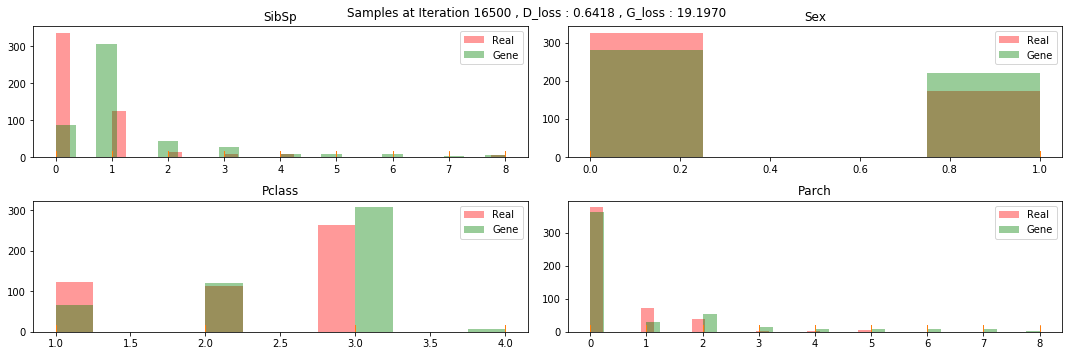

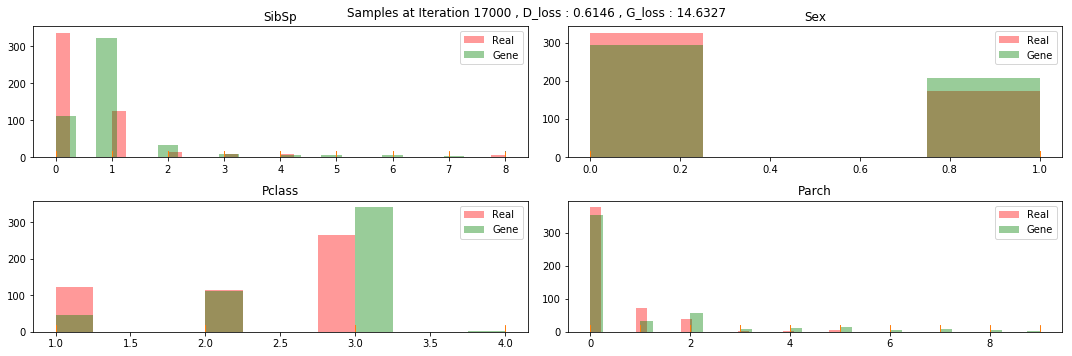

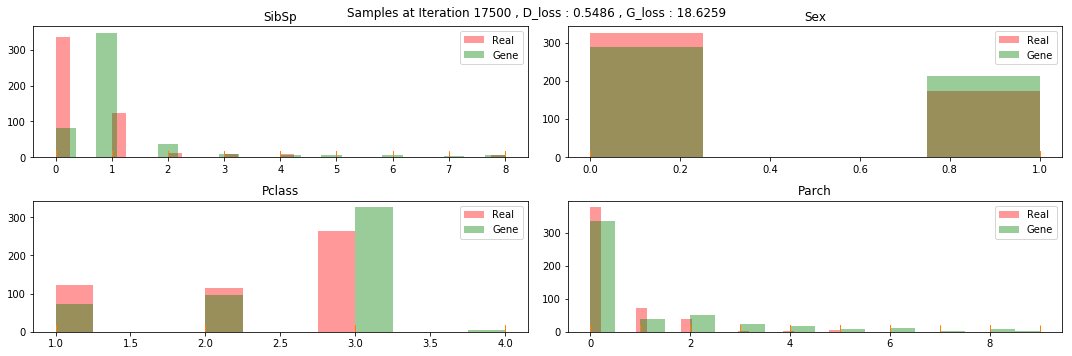

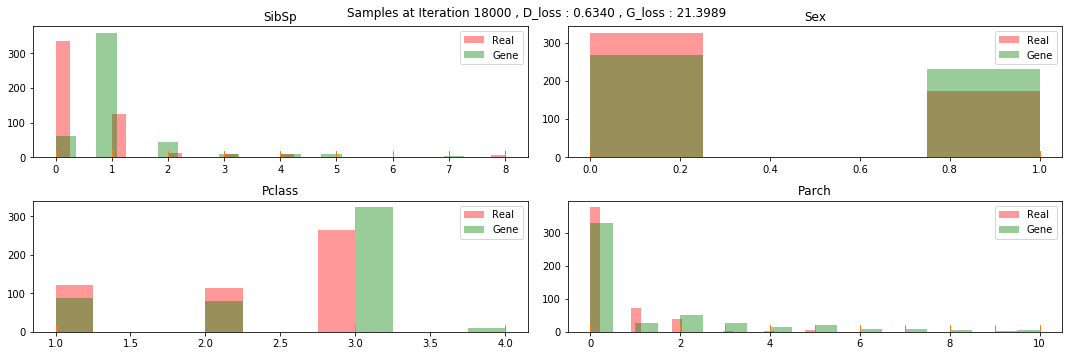

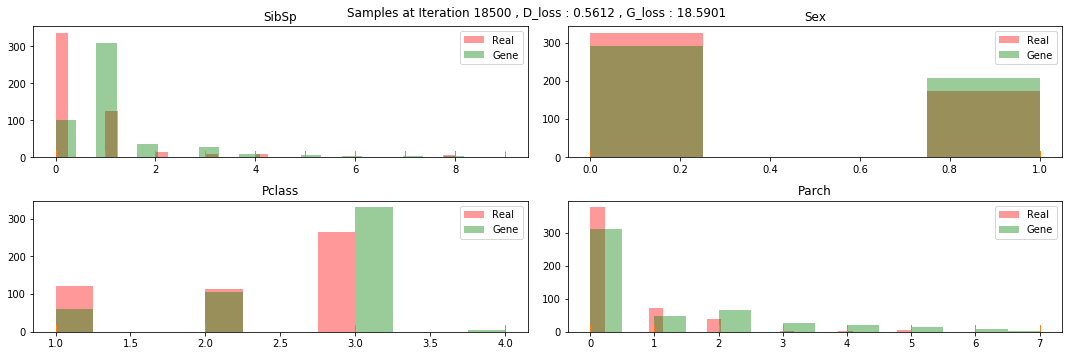

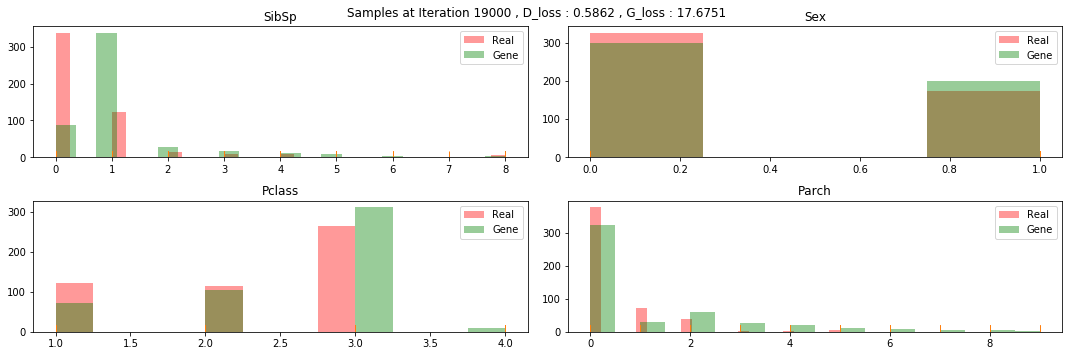

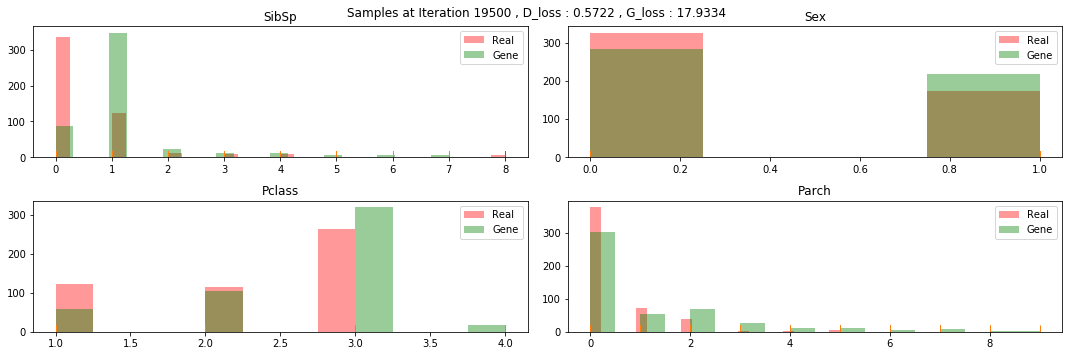

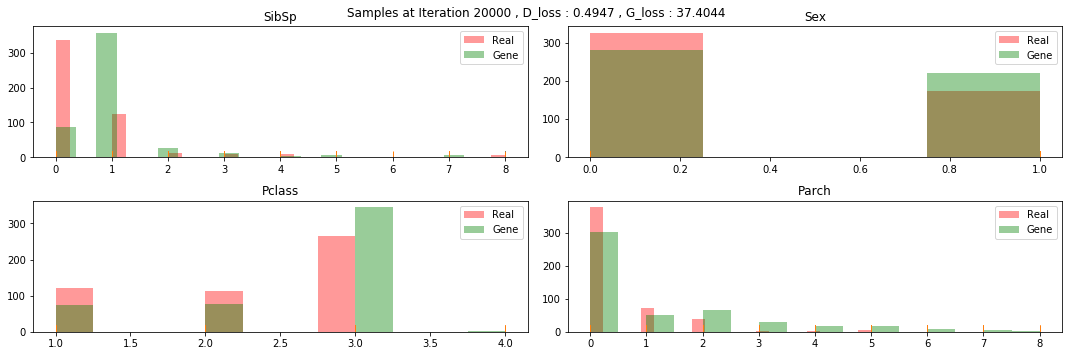

In [11]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 500
nd_steps = 10
ng_steps = 10

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(20001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size , input_dim )

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    #print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
    if i%10 == 0:
        f.write("%d,%f,%f\n"%(i,dloss,gloss))
    
    if i% 500 == 0:
        fig = plt.figure(figsize = (15,5))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
        ax1.title.set_text(feature[0])
        ax2.title.set_text(feature[1])
        ax3.title.set_text(feature[2])
        ax4.title.set_text(feature[3])
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        g_plot = np.around( g_plot  , decimals = 0 )
        sns.distplot(x_plot[:,0],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"r"}, ax = ax1, label = "Real")
        sns.distplot(g_plot[:,0],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"g"}, ax = ax1, label = "Gene")
        sns.distplot(x_plot[:,1],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"r"}, ax = ax2, label = "Real")
        sns.distplot(g_plot[:,1],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"g"}, ax = ax2, label = "Gene")
        sns.distplot(x_plot[:,2],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"r"}, ax = ax3, label = "Real")
        sns.distplot(g_plot[:,2],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"g"}, ax = ax3, label = "Gene")
        sns.distplot(x_plot[:,3],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"r"}, ax = ax4, label = "Real")
        sns.distplot(g_plot[:,3],norm_hist =False , rug=True , kde=False , hist_kws ={"color":"g"}, ax = ax4, label = "Gene")
        ax1.legend()
        ax2.legend()
        ax3.legend()
        ax4.legend()

#         xax = sns.distplot(x_plot, kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"})
#         gax = sns.distplot(g_plot, kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"})

        #plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.suptitle('Samples at Iteration %d , D_loss : %.4f , G_loss : %.4f'%(i,dloss,gloss) )
        plt.tight_layout()
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.show()

#         plt.figure()
#         rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
#         rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
#         grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
#         grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


#         plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))
#         plt.title('Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_%d.png'%i)
#         plt.show()

#         plt.figure()

#         rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
#         rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
#         grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
#         grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

#         plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
#                                "Generated Data Before G step","Generated Data After G step"))

#         plt.title('Centroid of Transformed Features at Iteration %d'%i)
#         plt.tight_layout()
#         #plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
#         plt.show()

f.close()


* 아주 쉬운 것도 Iteration이 2000 이상은 되야 잘 나온다.
* titanic에 적용해보기 지금 데이터는 integer 데이터로만 이루어진 데이터
* 여러개를 하니 분포를 잘 학습하는 것을 알 수 있다. 
* 여기선 신기하게도 Scaling 안해줘도 아주아주 잘된다 
* 1100개에서 batch 32 -> 500 으로 늘리니 먼가 더 잘되는 것을 확인 하였다.
* 어떤게 학습이 되면 어떤 것은 학습이 잘 되는 현상이 발생
* iteration 을 많이 해줘야 결과가 유의미하게 나올 것 같다.
* hsize = [16 ,16 ] -> [16 , 16 ,16 ] 으로 늘리니 잘 안됬다.
* hsize = [16 ,16 ] -> [24 , 24 ] 으로 늘리니 잘 되는 것 같다!!!
* 10000 -> 20000 으로 늘리니 잘 되 보인다.
* 만약 데이터 분포가 다를 경우에도 잘 될지 궁금하다. 
    * numeric ( 0 ~ 1 ) / ( 50 ~ 500) 

# Question
* 1. LOSS 만들기 전에 ROUND 하게 되면 어떤 효과를 받게 될까!
    * 실험 결과
    * Floor_G =  tf.floor(G_sample) 
    * residual = tf.subtract(Floor_G , G_sample) 
    * 이런식으로 첨가를 해서 해보는데 먼가 더 잘 되보인다. 
    * 먼가 근데 분포를 잘 학습을 못해보이기도 한다.
    * 그래서 자체적으로 LOSS 에다가 10 을 더 부여했다.
        * 더 분포를 학습하는 것 같다.
        * 성별이 학습이 안된다 GEN LOSS가 상대적으로 더 크다. 
        * [24 ,24] -> [24,24,24] 넣으니 성별이 완벽하게... 대박...
       
* 2. 이제는 시도 해볼 것은 numeric data에 대해서 그냥 놔두고 integer 데이터에 대해서는  따로 처리를  해주는 방식을 어떻게 진행할지 구조를 짜는 문제가 남아있다.
   
   